#### Import calls

In [ ]:
import distutils.util
import os

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import mujoco.viewer
import time
import itertools
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

# import from other python files
from pend_utils import pd_control
# from cane_builder import CaneEditor

Checking that the installation succeeded:
Installation successful.


#### Let's build the tree!

In [2]:
branch_model = """
<mujoco model="single_pendulum">
  <option gravity="0 0 -10"/>
  <option integrator="RK4"/>
  <compiler angle="radian"/>

  <worldbody>
    <light name="top" pos="-.5 0 1.5"/>

    <!-- tiny blue box -->
    <geom size="0.025 0.025 0.025" type="box" rgba="0 0 1 1"/>

    <!-- branch -->
    <body name="branch_link">
      <inertial pos="0 0 0.395" mass="0.05052" diaginertia="0.01051 0.01051 9.338e-07"/>
      <joint name="base_branch_joint" type="hinge" pos="0 0 0" axis="0 1 0"/>
      <geom size="0.00608 0.395" pos="0 0 0.395" type="cylinder" rgba="0 1 0 1"/>
    </body>
  </worldbody>

  <!-- Define actuators -->
  <actuator>
    <motor joint="base_branch_joint" name="base_torque"/>
  </actuator>

  <keyframe>
    <key name="initial" qpos=".1" qvel="-.1" />
  </keyframe>
</mujoco>
"""

In [ ]:
class CaneEditor():
    def __init__(self, xml_name):
        self.spec = mujoco.MjSpec.from_string(xml_name)
        self.model = self.spec.compile()

        self.spec.modelname = "edited model"
        geoms = self.spec.worldbody.find_all(mujoco.mjtObj.mjOBJ_GEOM)
        geoms[0].rgba = [1, 0, 0, 1]
        self.model = self.spec.compile()
        with mujoco.Renderer(self.model) as renderer:
            media.show_image(renderer.render())

""

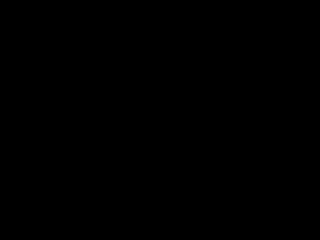

In [3]:
editor = CaneEditor(branch_model)

In [ ]:
model = mujoco.MjModel.from_xml_string(branch_model)
data = mujoco.MjData(model)

model.opt.timestep = .0001

duration = 2
framerate = 60

Kp = np.array([295])
Kd = np.array([.15])
init_angles = np.zeros(model.njnt)

timevals = []
posvals = []

frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    pd_control(model, data, Kp, Kd, init_angles)
    mujoco.mj_step(model, data)
    timevals.append(data.time)
    posvals.append(data.qpos.copy())
    if len(frames) < data.time*framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)
  

In [ ]:
dpi = 120
width = 1200
height = 400
figsize = (width/dpi, height/dpi)
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
ax.plot(timevals, posvals)

ax.set_title("Pendulum Position")
ax.set_ylabel("Pend Pos (radians)")
ax.set_xlabel("Time (seconds)")

In [ ]:
print(model.opt.timestep )